# Konvektions - Diffusionsgleichungen

Trefen Konvektion und Diffusion gemeinsam auf, erhält man die Konvektions-Diffusionsgleichung. Als Beispiel betrachten wir das Problem im eindimensionalen

$$\begin{split}
-\frac{d}{dx}(\epsilon\, u'(x) - b(x) u(x)) & = f(x)\quad \forall\ x\in(0,1)\\
u(x) & = u_g(x)\quad \forall x\in\{0,1\}\end{split}$$

Da dies eine Gleichung 2. Ordnung ist, dürfen zwei Randbedingungen gestellt werden. Interessant ist der Fall mit $\epsilon \ll b$. Im Grenzfall $\epsilon = 0$ hat man die Transportgleichung erster Ordnung, für die nur eine Randbedingung gestellt werden darf. Bei $\epsilon \to 0$ ändert sich der Typ der Gleichung.

Wir betrachten das konkrete Beispiel

$$\begin{split}
-\epsilon u''(x) + u'(x) & = 1\quad \text{für}\ x\in(0,1)\\
u(0) = u(1) & = 0.\end{split}$$ (eq:BeispielDiffusionKonvektion1dRWP)

Die analytische Lösung ist gegeben durch

$$u(x) = \frac{x\, e^{1/\epsilon}-e^{x/\epsilon }-x+1}{e^{1/\epsilon}-1} = x + \frac{1}{1-e^{-1/\epsilon}} \left(e^{(x-1)/\epsilon} - e^{-1/\epsilon}\right)$$

und zeigt eine Grenzschicht am Ausflussrand (vgl. {numref}`fig-KonvektionDiffusionBspAnalytic`).

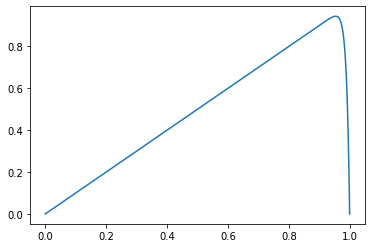

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from myst_nb import glue

def uanalytical(x,epsilon):
    return (np.exp(-1/epsilon)-np.exp(x/epsilon-1/epsilon)-x*np.exp(-1/epsilon)+x)/(1-np.exp(-1/epsilon))

xp = np.linspace(0,1,400)
fig, ax = plt.subplots()
ax.plot(xp,uanalytical(xp,1e-2))

glue("KonvektionDiffusionBspAnalytic", fig, display=False)

```{glue:figure} KonvektionDiffusionBspAnalytic
---
figwidth: 400px
name: fig-KonvektionDiffusionBspAnalytic
---

Analytische Lösung des Randwertproblem {eq}`eq:BeispielDiffusionKonvektion1dRWP`
```


```{admonition} Aufgabe
Löse das Randwertproblem {eq}`eq:BeispielDiffusionKonvektion1dRWP` mit Hilfe der finiten Differenzen Methode.
```

Die schwache Gleichung für das Randwertproblem {eq}`eq:BeispielDiffusionKonvektion1dRWP` ist geben durch

$$\int_0^1\epsilon\ u'\cdot v' dx + \int_0^1 u'\cdot v dx = \int_0^1 1\cdot v dx \quad \forall v\in H_0^1(0,1).$$

Wir diskretisieren daher das Intervall $[0,1]$ und erstellen ein 1D-Mesh.

In [2]:
from netgen.meshing import Mesh as NGMesh # Vorsicht es gibt Mesh auch in ngsolve!
from netgen.meshing import MeshPoint, Pnt, Element1D, Element0D
from ngsolve import *

In [3]:
ngmesh = NGMesh()
ngmesh.dim = 1

nel = 5

pnums = []
for i in range(0, nel+1):
    pnums.append (ngmesh.Add (MeshPoint (Pnt(i/nel, 0, 0))))

for i in range(0,nel):
    ngmesh.Add (Element1D ([pnums[i],pnums[i+1]], index=1))

ngmesh.Add (Element0D (pnums[0], index=1))
ngmesh.Add (Element0D (pnums[nel], index=2))

mesh = Mesh(ngmesh)

## H1-FEM Lösung

Als erstes betrachten wir die Lösung mit H1 FEM Ansatz.

In [4]:
order = 1
V = H1(mesh, order=order, dirichlet=[1,2])
print ("freedofs:\n", V.FreeDofs())

freedofs:
 0: 011110


Der Paramter $\epsilon$ implementieren wir als NGSolve `Parameter`. Das hat den Vorteil, dass wir die Lösung für verschiedene Werte einfach berechnen können.

In [5]:
epsilon = Parameter(0.02)

In [6]:
# Trial und Test Functions für die Definition
u,v = V.TnT()

# Bilinearform
a = BilinearForm(V)
a += epsilon*grad(u)*grad(v)*dx
a += grad(u)*v*dx

# Linearform
f = LinearForm(V)
f += CoefficientFunction(1)*v*dx

In [7]:
epsilon.Set(2e-2)
a.Assemble()
f.Assemble()

# Lösung berechnen
gfu = GridFunction(V)
gfu.vec.data = a.mat.Inverse(V.FreeDofs()) * f.vec

Die 1D Lösung visualisieren wir direkt mit Hilfe der `matplotlib`:

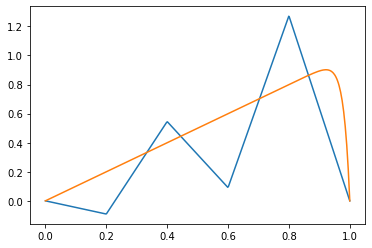

In [8]:
plt.plot(xp,gfu(mesh(xp)))
plt.plot(xp,uanalytical(xp,epsilon.Get()))
plt.show()

Wenn $\epsilon$ klein wird, gibt es ein Problem...

In [9]:
uanalyticalNGS = (exp(-1/epsilon)-exp(x/epsilon-1/epsilon)-x*exp(-1/epsilon)+x)/(1-exp(-1/epsilon))
res = (uanalyticalNGS-gfu)
errorCont=Integrate(res**2,mesh)
print('L2 error = ', errorCont)

L2 error =  0.06530809397435235


**Bemerkung**: Auch im 2D, 3D muss man bei Konvektions-Diffusionsgleichungen sehr vorsichtig sein. Das Problem zeigt sich dort ebenso. Sallop formuliert entsteht das Problem, wenn die Dynamik der Lösung mit dem gegebenen Mesh nicht abgebildet werden kann. Der numerische Ansatz wird **instabil**.

## DG-FEM Lösung

Als kleiner Input am Rand sei hier die Discontiuous Gallerkin finite Elemente Methode (DG-FEM) erwähnt. Die Methoden sind im Vergleich zu den $H^1$ Diskretisierungen jung. Insbesondere im Bereich der Strömungsprobleme, bei denen in der Regel konvektive Terme in den Gleichungen vorkommen sind die DG-FEM und noch neueren hybrid DG-FEM Ansätze sehr interessant. Nebst Stabilitätsprobleme kann auch die Volumenerhaltung analog zu den finite Volumen Methoden stets garantiert werden (lokal wie auch global). Wir verlassen an dieser Stelle jedoch definitiv den Rahmen dieses Moduls.

In [10]:
VDG = L2(mesh, order=order, flags={"dgjumps":True})
print ("freedofs:\n", VDG.FreeDofs())
u,v = VDG.TnT()

freedofs:
 0: 1111111111


Da die Diskretisierung nicht mehr eine stetige Lösung verlangt (deshalb discontiuous) müssen wir für die Stabilisierung Sprungterme in den Gleichungen einbauen. Wir setzen das hier ohne auf die Details einzugehen einfach um:

In [11]:
jump_u = u-u.Other()
jump_v = v-v.Other()
n = specialcf.normal(1)
mean_dudn = 0.5*n * (grad(u)+grad(u.Other()))
mean_dvdn = 0.5*n * (grad(v)+grad(v.Other()))

alpha = 4
h = specialcf.mesh_size
aDG = BilinearForm(VDG)
aDG += SymbolicBFI(epsilon*grad(u)*grad(v))
aDG += SymbolicBFI(epsilon*alpha*order**2/h*jump_u*jump_v, skeleton=True)
aDG += SymbolicBFI(-epsilon*mean_dudn*jump_v -epsilon*mean_dvdn*jump_u, skeleton=True)
aDG += SymbolicBFI(epsilon*alpha*order**2/h*u*v, BND, skeleton=True)
aDG += SymbolicBFI(-epsilon*n*grad(u)*v-epsilon*n*grad(v)*u, BND, skeleton=True)
aDG += SymbolicBFI(-u*grad(v))
aDG += SymbolicBFI(n*IfPos(n[0],u,u.Other())*jump_v, skeleton=True)
aDG += SymbolicBFI(n*IfPos(n[0],u,0)*v, BND, skeleton=True)
aDG.Assemble()

Für die Linearform ändert sich nichts (abgesehen vom FE-Space):

In [12]:
fDG = LinearForm(VDG)
fDG += SymbolicLFI(1*v)
fDG.Assemble()

In [13]:
gfuDG = GridFunction(VDG)
gfuDG.vec.data = aDG.mat.Inverse(VDG.FreeDofs()) * fDG.vec

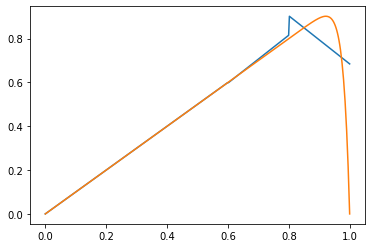

In [14]:
plt.plot(xp,gfuDG(mesh(xp)))
plt.plot(xp,uanalytical(xp,epsilon.Get()))

In [15]:
resDG = (uanalyticalNGS-gfuDG)
errorDG=Integrate(resDG**2,mesh)
print('L2 error DG = ', errorDG)
print('L2 error Cont = ', errorCont)

L2 error DG =  0.001238086457470046
L2 error Cont =  0.06530809397435235


```{admonition} Aufgabe
Diskutiere die $\epsilon$ Abhängigkeit des L2 Fehlers im Bereich $\epsilon \in [10^{-5},10]$ mit einer logarithmischen Skala.
```

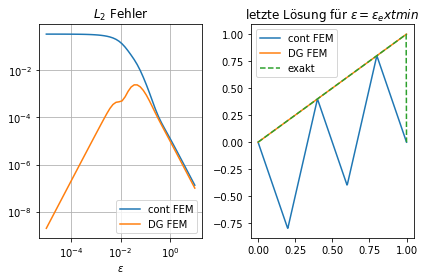

In [25]:
epsilons = 10**np.linspace(1,-5)

errorsCG = []
errorsDG = []
for eps in epsilons:
    epsilon.Set(eps)
    # cont FEM
    a.Assemble()
    gfu.vec.data = a.mat.Inverse(V.FreeDofs()) * f.vec
    errorsCG.append(Integrate(res**2,mesh))
    # DG FEM
    aDG.Assemble()
    gfuDG.vec.data = aDG.mat.Inverse(VDG.FreeDofs()) * fDG.vec
    errorsDG.append(Integrate(resDG**2,mesh))

figsol, (ax1,ax2) = plt.subplots(1,2)
ax1.loglog(epsilons,errorsCG)
ax1.loglog(epsilons,errorsDG)
ax1.legend(['cont FEM','DG FEM'])
ax1.set_title('$L_2$ Fehler')
ax1.set_xlabel('$\epsilon$')
ax1.grid()

ax2.plot(xp,gfu(mesh(xp)))
ax2.plot(xp,gfuDG(mesh(xp)))
ax2.plot(xp,uanalytical(xp,epsilon.Get()),'--')
ax2.set_title('letzte Lösung für $\epsilon = \epsilon_\text{min}$')
ax2.legend(['cont FEM','DG FEM', 'exakt'])
figsol.set_tight_layout('tight')

glue("KonvektionDiffusionBspAnalyticSol", figsol, display=False)

```{glue:figure} KonvektionDiffusionBspAnalyticSol
---
figwidth: 400px
name: fig-KonvektionDiffusionBspAnalyticSol
---

Vergleich H1-FEM vs DG-FEM.
```